# An extension of 4
Here we show how to build a basic neural network for identifying dog or muffin

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt # plotting
from skimage.io import imread # read in images
from skimage.segmentation import mark_boundaries # mark labels
from sklearn.metrics import roc_curve, auc # roc curve tools
from skimage.color import label2rgb
import numpy as np # linear algebra / matrices
# make the notebook interactive
from ipywidgets import interact, interactive, fixed 
import ipywidgets as widgets #add new widgets
from IPython.display import display
import os

In [2]:
base_path = '04-files'
seg_path = os.path.join(base_path,'DogVsMuffin_seg_bw.jpg')
rgb_path = os.path.join(base_path,'DogVsMuffin.jpg')
face_path = os.path.join(base_path,'DogVsMuffin_face.jpg')
seg_img = imread(seg_path)[80:520,:450]
rgb_img = imread(rgb_path)[80:520,:450,:]
face_img = imread(face_path)
print('RGB Size',rgb_img.shape,'Seg Size',seg_img.shape,'Face Size',face_img.shape)

RGB Size (440, 450, 3) Seg Size (440, 450) Face Size (111, 131, 3)


# Calculate the baseline ROC curve

In [3]:
ground_truth_labels = seg_img.flatten()>0
score_value = 1-np.mean(rgb_img.astype(np.float32),2).flatten()/255.0
fpr, tpr, _ = roc_curve(ground_truth_labels,score_value)
roc_auc = auc(fpr,tpr)

Text(0.5,1,'Labeled Image')

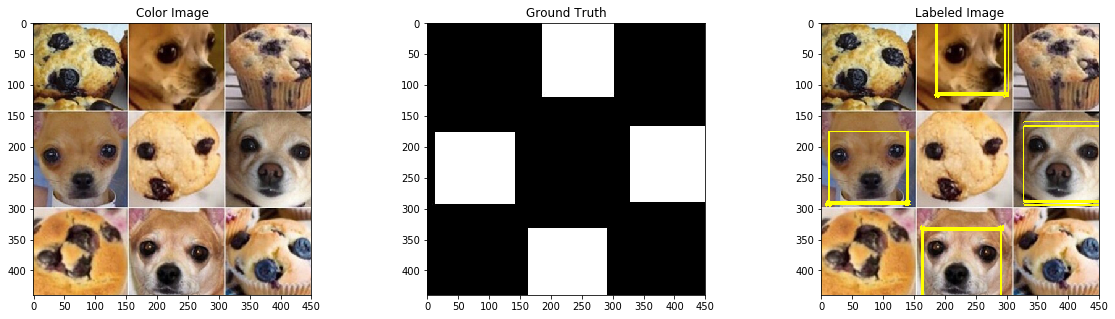

In [4]:
%matplotlib inline
fig, (ax1, ax2, ax3) = plt.subplots(1,3,figsize = (20,5))
ax1.imshow(rgb_img) # show the color image
ax1.set_title("Color Image")
ax2.imshow(seg_img, cmap='gray') # show the segments
ax2.set_title("Ground Truth")
ax3.imshow(mark_boundaries(rgb_img,seg_img))
ax3.set_title("Labeled Image")

In [5]:
from keras.models import Sequential
from keras.layers import Conv2D, BatchNormalization, Input
simple_model = Sequential(name = 'SingleConvLayer')
simple_model.add(BatchNormalization(input_shape = (None, None, 3)))
simple_model.add(Conv2D(1, kernel_size = (25, 25), activation = 'sigmoid', padding = 'same'))
simple_model.compile(optimizer = 'sgd', loss = 'binary_crossentropy', metrics = ['binary_accuracy', 'mse'])
simple_model.summary()

/Users/mader/anaconda/envs/qbi2018/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.
/Users/mader/anaconda/envs/qbi2018/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: compiletime version 3.5 of module 'tensorflow.python.framework.fast_tensor_util' does not match runtime version 3.6
  return f(*args, **kwds)


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
batch_normalization_1 (Batch (None, None, None, 3)     12        
_________________________________________________________________
conv2d_1 (Conv2D)            (None, None, None, 1)     1876      
Total params: 1,888
Trainable params: 1,882
Non-trainable params: 6
_________________________________________________________________


In [6]:
simple_model.fit(np.expand_dims(rgb_img,0), 
                 np.expand_dims(np.expand_dims(seg_img/255.0, -1),0), 
                 epochs=1)

Epoch 1/1
1/1 [==============================] - 4s 4s/step - loss: 0.8674 - binary_accuracy: 0.4085 - mean_squared_error: 0.3223


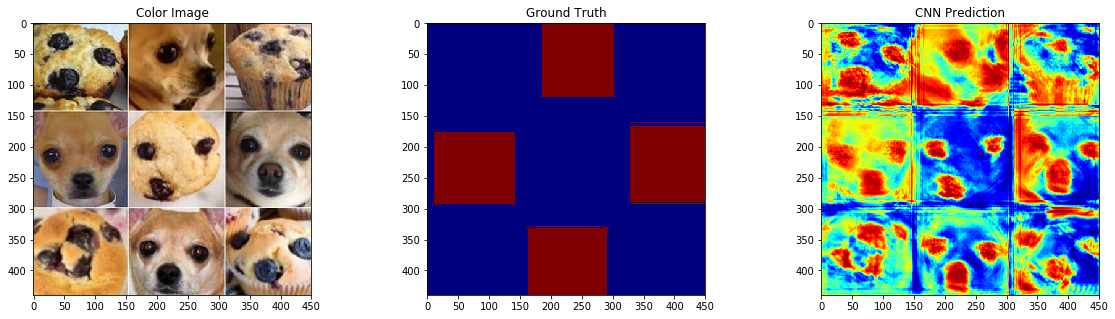

In [7]:
%matplotlib inline
fig, (ax1, ax2, ax3) = plt.subplots(1,3,figsize = (20,5))
ax1.imshow(rgb_img) # show the color image
ax1.set_title("Color Image")
ax2.imshow(seg_img, vmin = 0, vmax = 1, cmap = 'jet') # show the segments
ax2.set_title("Ground Truth")
m_output = simple_model.predict(np.expand_dims(rgb_img,0))
ax3.imshow(m_output[0, :, :, 0], vmin = 0, vmax = 1, cmap = 'jet')
ax3.set_title("CNN Prediction");

In [8]:
loss_history = simple_model.fit(np.expand_dims(rgb_img,0), 
                 np.expand_dims(np.expand_dims(seg_img/255.0, -1),0), 
                 epochs=10, 
                                verbose = False)
loss_history.history['binary_accuracy'][-1]

0.600787878036499

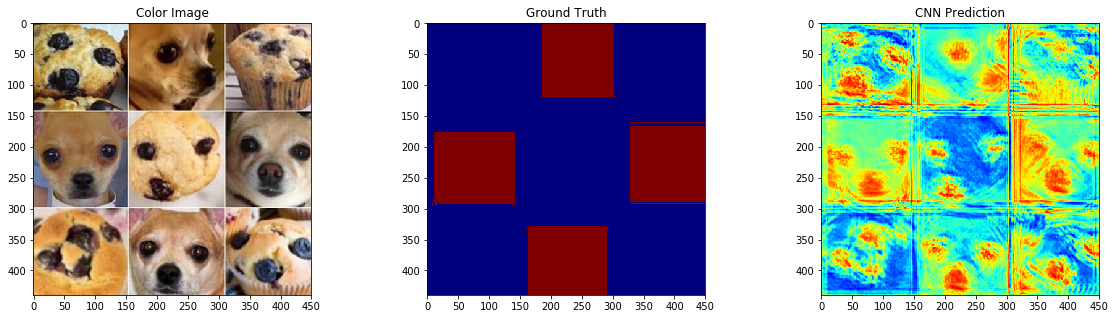

In [9]:
%matplotlib inline
fig, (ax1, ax2, ax3) = plt.subplots(1,3,figsize = (20,5))
ax1.imshow(rgb_img) # show the color image
ax1.set_title("Color Image")
ax2.imshow(seg_img, vmin = 0, vmax = 1, cmap = 'jet') # show the segments
ax2.set_title("Ground Truth")
m_output = simple_model.predict(np.expand_dims(rgb_img,0))
ax3.imshow(m_output[0, :, :, 0], vmin = 0, vmax = 1, cmap = 'jet')
ax3.set_title("CNN Prediction");

In [10]:
fpr_cnn, tpr_cnn, _ = roc_curve(ground_truth_labels,m_output.ravel())
roc_auc_cnn = auc(fpr_cnn,tpr_cnn)

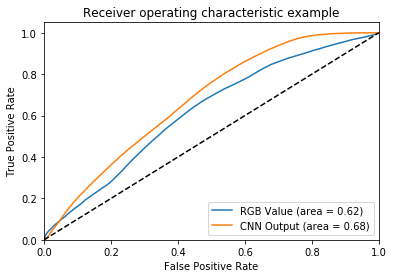

In [11]:
%matplotlib inline
fig, ax = plt.subplots(1,1)
ax.plot(fpr, tpr, label='RGB Value (area = %0.2f)' % roc_auc)
ax.plot(fpr_cnn, tpr_cnn, label='CNN Output (area = %0.2f)' % roc_auc_cnn)
ax.plot([0, 1], [0, 1], 'k--')
ax.set_xlim([0.0, 1.0])
ax.set_ylim([0.0, 1.05])
ax.set_xlabel('False Positive Rate')
ax.set_ylabel('True Positive Rate')
ax.set_title('Receiver operating characteristic example')
ax.legend(loc="lower right")

In [12]:
from keras.preprocessing.image import ImageDataGenerator
idg = ImageDataGenerator(rotation_range = 2, 
                   zoom_range = 0.1, 
                   width_shift_range = .1, 
                   height_shift_range=0.1, 
                   vertical_flip=True, 
                   horizontal_flip=True)
img_gen = idg.flow(np.expand_dims(rgb_img,0), seed = 1234) 
seg_gen = idg.flow(np.expand_dims(np.expand_dims(seg_img/255.0, -1),0), seed = 1234)

In [13]:
simple_model.fit_generator(zip(img_gen, seg_gen), steps_per_epoch=5, epochs=5)

Epoch 1/5
5/5 [==============================] - 21s 4s/step - loss: 0.6661 - binary_accuracy: 0.6004 - mean_squared_error: 0.2356
Epoch 2/5
5/5 [==============================] - 21s 4s/step - loss: 0.6698 - binary_accuracy: 0.6027 - mean_squared_error: 0.2368
Epoch 3/5
5/5 [==============================] - 21s 4s/step - loss: 0.6445 - binary_accuracy: 0.6233 - mean_squared_error: 0.2260
Epoch 4/5
5/5 [==============================] - 19s 4s/step - loss: 0.6434 - binary_accuracy: 0.6226 - mean_squared_error: 0.2257
Epoch 5/5
5/5 [==============================] - 17s 3s/step - loss: 0.6357 - binary_accuracy: 0.6309 - mean_squared_error: 0.2223


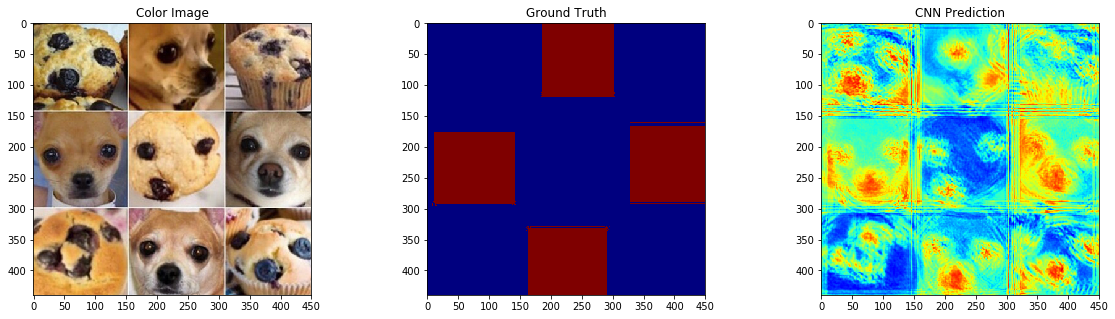

In [14]:
%matplotlib inline
fig, (ax1, ax2, ax3) = plt.subplots(1,3,figsize = (20,5))
ax1.imshow(rgb_img) # show the color image
ax1.set_title("Color Image")
ax2.imshow(seg_img, vmin = 0, vmax = 1, cmap = 'jet') # show the segments
ax2.set_title("Ground Truth")
m_output = simple_model.predict(np.expand_dims(rgb_img,0))
ax3.imshow(m_output[0, :, :, 0], vmin = 0, vmax = 1, cmap = 'jet')
ax3.set_title("CNN Prediction");

### Tasks
1. How can you improve the neural network model (what can you add, or change)?
2. Where might morphological operations fit in?
3. What is wrong with our approach for validating the model here? (what data are we using to measure the accuracy)

